In [2]:

from __future__ import print_function
import keras
from keras.datasets import mnist
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils import shuffle
import sys


Using TensorFlow backend.


In [8]:
# input image dimensions
img_rows, img_cols = 28, 28

In [9]:
batch_size = 128
num_classes = 10
epochs = 50


In [10]:
# the data, split between train and test sets
(x_train, y_train), (x_test, y_test) = mnist.load_data()

In [11]:
x_train.shape

(60000, 28, 28)

In [23]:
iterations = np.ceil((x_train.shape[0]*epochs)/batch_size)

iterations_per_epoch = np.ceil((x_train.shape[0])/batch_size)

num_batch = int(x_train.shape[0]/batch_size)

In [13]:
x_train=np.array([i.flatten() for i in x_train])
x_test=np.array([i.flatten() for i in x_test])


In [14]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test = keras.utils.to_categorical(y_test, num_classes)

In [15]:
# Function to create individual model
def k_model(output_dim,input_dim):
    model = Sequential() 
    model.add(Dense(output_dim, input_dim=input_dim, activation='sigmoid')) 
    return model

In [39]:
# Function to show the loss plot of training and validation set
def loss(history):
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Test'], loc='upper left')
    plt.show()

### Baseline model 
Got one layer that maps input to 10 classes

In [78]:
base_model=k_model(10,784)
base_model.compile(loss=keras.losses.categorical_crossentropy,
              optimizer=keras.optimizers.SGD(lr=0.01, momentum=0.0, nesterov=False),
              metrics=['accuracy'])
base_model.fit(x_train, y_train,
          batch_size=batch_size,
          epochs=epochs,
          verbose=1,
          validation_data=(x_test, y_test))

Train on 60000 samples, validate on 10000 samples
Epoch 1/50
60000/60000 [==============================] - 2s 38us/step - loss: 2.2696 - acc: 0.1775 - val_loss: 2.1202 - val_acc: 0.2119
Epoch 2/50
60000/60000 [==============================] - 1s 24us/step - loss: 2.0563 - acc: 0.2820 - val_loss: 1.9509 - val_acc: 0.3692
Epoch 3/50
60000/60000 [==============================] - 1s 24us/step - loss: 1.9399 - acc: 0.3558 - val_loss: 1.9147 - val_acc: 0.3335
Epoch 4/50
60000/60000 [==============================] - 1s 23us/step - loss: 1.9015 - acc: 0.3555 - val_loss: 1.8975 - val_acc: 0.3885
Epoch 5/50
60000/60000 [==============================] - 1s 23us/step - loss: 1.8756 - acc: 0.3696 - val_loss: 1.8219 - val_acc: 0.4284
Epoch 6/50
60000/60000 [==============================] - 1s 23us/step - loss: 1.7577 - acc: 0.3942 - val_loss: 1.7127 - val_acc: 0.4277
Epoch 7/50
60000/60000 [==============================] - 1s 23us/step - loss: 1.7263 - acc: 0.4221 - val_loss: 1.7026 - val_acc

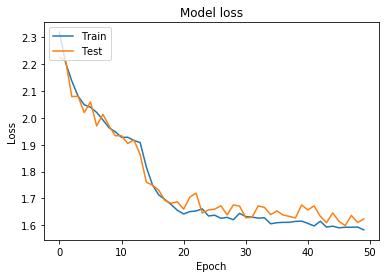

In [38]:
loss(base_model)

In [346]:
base_model.evaluate(x_train, y_train)

60000/60000 [==============================] - 6s 107us/step


[1.4674661699930827, 0.4931833333333333]

In [332]:
base_model.get_weights()

[array([[ 0.00501547, -0.00674535, -0.06097253, ..., -0.05963147,
         -0.07018973, -0.0724439 ],
        [-0.07141563, -0.0340202 ,  0.01036116, ..., -0.02430729,
         -0.03875604,  0.0808486 ],
        [-0.07387179, -0.00476275, -0.0778629 , ...,  0.06672233,
         -0.03074042,  0.06059032],
        ...,
        [ 0.00239176,  0.06713601,  0.06921119, ..., -0.07678283,
          0.07359213, -0.05700356],
        [ 0.08325469, -0.00927467,  0.04573277, ...,  0.06145666,
         -0.06782161,  0.00983036],
        [ 0.01637364, -0.01756142, -0.05072362, ..., -0.07511865,
         -0.04097176, -0.02354608]], dtype=float32),
 array([-0.00317706, -0.0003361 ,  0.00075525, -0.00105265, -0.00019839,
         0.00018287, -0.00152985,  0.00208376, -0.0046165 ,  0.00030399],
       dtype=float32)]

### Local SGD

Below is the list of variables:
1. Number of nodes
2. Learning rate
3. Time step
4. Data - Distributed/Not distributed

In [3]:
def list_model(n):
    l = []
    for i in range(n):
         l.append(k_model(10,784))
    
    return l

In [19]:
def define_model(n,alpha):
    models = list_model(n)
    

    num_batch = len(y_train) // batch_size

    
    #        c.append(0)
    #        loss.append([])

    for i in models:
        i.compile(loss = keras.losses.categorical_crossentropy,
                    optimizer = keras.optimizers.SGD(lr = alpha, momentum = 0.0, nesterov = False, clipvalue=0.5),
                    metrics=['accuracy'])
    
    return models

In [20]:
def local_sgd(n,t,alpha):
    c = 0
    batch_x = 0
    batch_y = 0
    train_loss = []
    test_loss = []
    itr = int(iterations / t)
    models = define_model(n,alpha)
    model_data = []
    
    for i in range(n):
        model_data.append(shuffle(x_train,y_train))
    
    for i in range(itr):
        weights = []
        for j in range(t):
            for k in range(len(models)):
                
                batch_x = model_data[k][0][c * batch_size: (c + 1) * batch_size]

                batch_y = model_data[k][1][c * batch_size: (c + 1) * batch_size]

                models[k].train_on_batch(batch_x, batch_y)
                c += 1
                c= c % num_batch


        for l in range(len(models)):
            weights.append(models[l].layers[0].get_weights())



        new_weight = weights[0]
        
        for l in range(1,n):
            if l !=n-1:
                new_layer=[j+k for j,k in zip(new_weight,weights[l])]
            else:
                new_layer=[(j+k)/n for j,k in zip(new_weight,weights[l])]


        sys.stdout.write('\rNumber of iterationss: ' + str(i) + ' of ' + str(itr))
        sys.stdout.flush()

        if i % 100 == 0:
            train_loss.append(models[0].evaluate(x_train,y_train)[0])
            test_loss.append(models[0].evaluate(x_test,y_test)[0])


        for l in range(len(models)):
            models[l].set_weights(new_weight)
        
        
    return (train_loss,test_loss)

In [21]:
Node_list = [2, 4, 6, 8, 16]
alpha = [0.001, 0.005, 0.01, 0.05, 0.1]
time = [1, 2, 4, 8, 16]


In [25]:
loss_2_8_001=local_sgd(2,8,0.001)

10000/10000 [==============================] - 0s 33us/step
Number of iterationss: 2928 of 2929

In [26]:
loss_4_8_001=local_sgd(4,8,0.001)

10000/10000 [==============================] - 0s 32us/step
Number of iterationss: 2928 of 2929

In [27]:
loss_8_8_001=local_sgd(8,8,0.001)

10000/10000 [==============================] - 0s 33us/step
Number of iterationss: 2928 of 2929

In [28]:
loss_16_8_001=local_sgd(16,8,0.001)

10000/10000 [==============================] - 0s 38us/step
Number of iterationss: 2928 of 2929

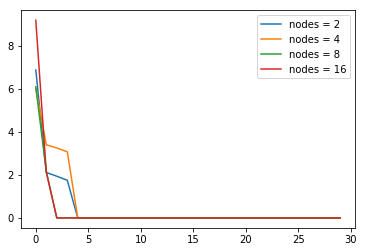

In [30]:
desc = ['nodes = 2', 'nodes = 4', 'nodes = 8', 'nodes = 16' ]
plt.plot(loss_2_8_001[0],label=desc[0])
plt.plot(loss_4_8_001[0],label=desc[1])
plt.plot(loss_8_8_001[0],label=desc[2])
plt.plot(loss_16_8_001[0],label=desc[3])
plt.legend()
plt.show()

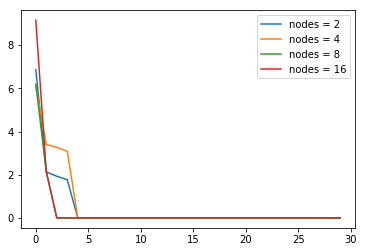

In [34]:
desc = ['nodes = 2', 'nodes = 4', 'nodes = 8', 'nodes = 16' ]
plt.plot(loss_2_8_001[1],label=desc[0])
plt.plot(loss_4_8_001[1],label=desc[1])
plt.plot(loss_8_8_001[1],label=desc[2])
plt.plot(loss_16_8_001[1],label=desc[3])
plt.legend()
plt.show()